Ответы на вопросы

1) Сравнить результат с LTV проекта – отношение LTV/CAC должно быть больше 3 (в данном случае CAC = 1000/50 = 20).

2) Определим метрики, которые хотим смотреть - ARPU и конверсия в платёж.
Рассчитываем размер выборки для A/B тестирования, исходя из минимального размера эффекта, который мы хотим получить, значения дисперсии на исторических данных по данным метрикам в Швейцарии, значений статистики t - в случае ARPU (используем t-критерий Стьюдента) и Z - в случае конверсии (Z test для биномиальной метрики) для заданных уровня значимости и мощности. Например, для t-критерия имеем формулу:

$MDE * \mu = (t_{\frac{\alpha}2}+t_{\beta})*\sigma*\sqrt{\frac 2n}$

Делим группы на контрольную и экспериментальную в соотношении 50/50, проводим А/A тест для проверки случайности разбиения на группы. Запускаем эксперимент, дожидаемся, пока наберётся необходимое количество элементов выборки. Далее если мы используем сервис для A/B тестирования - например, Firebase, можно смотреть на параметры probability to be best (должно быть 95%) и процентное изменение метрики. Также можно выгрузить данные эксперимента и проверить по ним гипотезу: 

$H_0$: средние значения метрики в контрольной и экспериментальной группах совпадают

$H_1$: обратное 

Альтернативную гипотезу принимаем при p-value < 0.05 для соответствующих значений статистики. 

Можно также измерять количественную метрику revenue, и сравнивать её средние значения для групп с помощью метода bootstrap.

3) Количество активных пользователей в месяц увеличилось, однако нужно также смотреть на метрику DAU - количество активных пользователей в день, чтобы понять, способствует ли эта фича удержанию пользователей на сайте

4) предсказанное значение с помощью методов временного ряда 1202263 $

In [342]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
from statsmodels.api import tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox 
from statsmodels.tsa.seasonal import STL

import warnings
warnings.filterwarnings('ignore')

In [173]:
def differencing(timeseries):
    l = timeseries.shape[0]-1
    ts_diff = np.zeros(l)
    for i in range(l):
        ts_diff[i] = timeseries.iloc[i+1,0]-timeseries.iloc[i,0]
    return pd.DataFrame(ts_diff)

In [345]:
df = pd.read_csv("test_data (1).csv")
df.head()

,Unnamed: 0,ts,user,payment
0,534543,2022-01-01 00:03:40.907,Kkkww7LxsEqojhi6i,101.000
1,534546,2022-01-01 00:53:16.300,botxbGKkKNaXfKGiR,41.000
2,534549,2022-01-01 03:50:03.295,bQbjq4PobqAFRcTy2,58.000
3,534550,2022-01-01 06:11:30.875,SXLpG8h4PmbF4Afeg,53.000
4,534551,2022-01-01 09:11:55.582,dLh5ehuYNXQDdPJ5C,17.052


In [339]:
df.shape[0]

34917

In [341]:
df.user.nunique()

9672

In [24]:
type(df.ts[0])

str

In [346]:
df.ts = pd.to_datetime(df.ts)

## Ежемесячная выручка 

In [350]:
df['month'] = df.ts.dt.to_period('D').dt.to_timestamp()
df.groupby('month', as_index = False).agg({'payment':'sum'})

,month,payment
0,2022-01-01,125583.44405
1,2022-02-01,122304.74531
2,2022-03-01,135702.28475
3,2022-04-01,129630.32295
4,2022-05-01,125434.95690
5,2022-06-01,107664.00200
6,2022-07-01,86557.63950
7,2022-08-01,100957.33599
8,2022-09-01,118115.96055
9,2022-10-01,112693.25433


In [26]:
df['ts'].dt.date.unique()

array([datetime.date(2022, 1, 1), datetime.date(2022, 2, 1),
       datetime.date(2022, 3, 1), datetime.date(2022, 4, 1),
       datetime.date(2022, 5, 1), datetime.date(2022, 6, 1),
       datetime.date(2022, 7, 1), datetime.date(2022, 8, 1),
       datetime.date(2022, 9, 1), datetime.date(2022, 10, 1),
       datetime.date(2022, 11, 1), datetime.date(2022, 12, 1)],
      dtype=object)

Покупки совершаются только в первый день месяца. Переделаем индексы датасета, чтобы убрать бесполезные нулевые значения и построим временной ряд, взяв среднее значение платежа за час.

In [73]:
df['year'] = df['ts'].dt.to_period('Y').dt.to_timestamp()
df['ts_new'] = df.ts.apply(lambda x: (x.month-1)*pd.Timedelta('1 days') + x.hour*pd.Timedelta('1 hours')) + df['year']

In [88]:
df['ts_new'].dt.month.unique()

array([1], dtype=int64)

In [90]:
df['ts_new'].dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [91]:
df.index = df.ts_new

In [225]:
df1 = df.payment.resample('H').sum()
df1.head()

ts_new
2022-01-01 00:00:00    2515.996
2022-01-01 01:00:00    1656.231
2022-01-01 02:00:00    1745.279
2022-01-01 03:00:00    1936.092
2022-01-01 04:00:00    1346.739
Freq: H, Name: payment, dtype: float64

In [226]:
df1.index = range(df1.shape[0])

<AxesSubplot:>

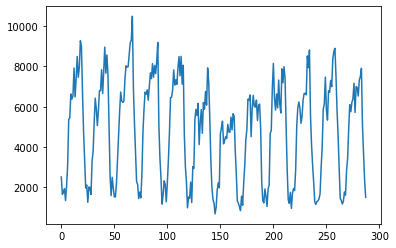

In [227]:
df1.plot()

Имеем временной ряд из $24*12 = 288$ значений, нужно предсказать следующие $288$ значений.

## Стабилизируем дисперсию с помощью логарифмирования

In [196]:
df1_log = pd.DataFrame(np.log(df1))

<AxesSubplot:>

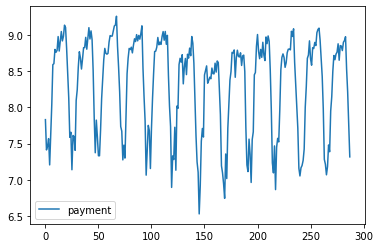

In [197]:
df1_log.plot()

## Проверим ряд на стационарность разными способами

Тест kpss на стационарность. 

$H_0$: временной ряд стационарен

$H_1$: временной ряд не стационарен

Если p-value для полученной статистики меньше 0.05, принимается альтернативная гипотеза.

In [198]:
tsa.stattools.kpss(df1_log)

(0.0662356471433736,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Имеем: p-value = 0.1 > 0.05 $\Rightarrow$ принимаем нулевую гипотезу, ряд стационарен.

Тест Дики-Фуллера на стационарность временного ряда.

$H_0$: временной ряд не стационарен

$H_1$: временной ряд стационарен

In [200]:
dftest = adfuller(df1_log, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -5.334577
p-value                          0.000005
#Lags Used                      16.000000
Number of Observations Used    271.000000
dtype: float64


Имеем: p-value < 0.05 $\Rightarrow$ принимаем альтернативную гипотезу, ряд стационарен.

## Избавимся от сезонности

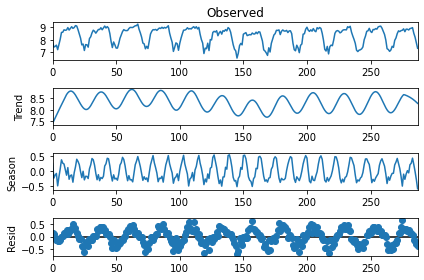

In [298]:
stl = STL(df1_log, period = 12)
res = stl.fit()
fig = res.plot()

<AxesSubplot:>

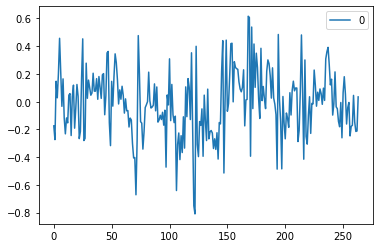

In [264]:
d = np.array(df1_log)
df_log_s = d[24:] - d[:-24]
ts = pd.DataFrame(df_log_s)
ts.plot()

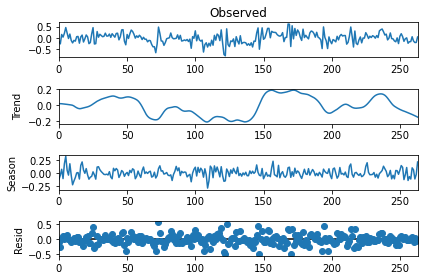

In [299]:
stl = STL(ts, period = 12)
res = stl.fit()
fig = res.plot()

## Посмотрим на графики АКФ и ЧАКФ для полученного ряда

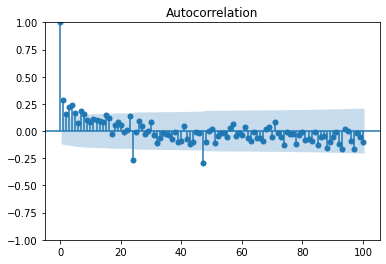

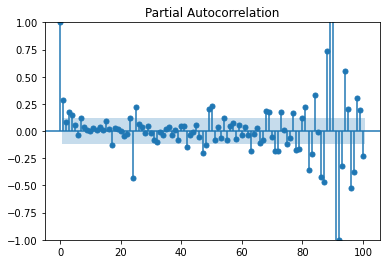

In [267]:
plot_acf(ts, lags = 100);
plot_pacf(ts, lags = 100);

Чтобы стабилизировать график, воспользуемся дифференцированием

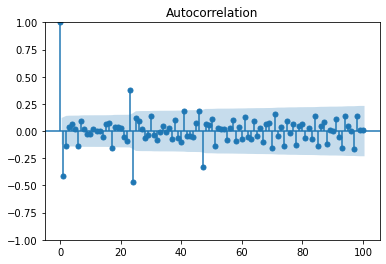

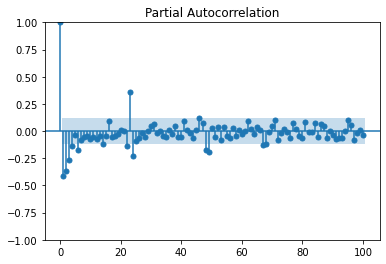

In [268]:
plot_acf(differencing(ts), lags = 100);
plot_pacf(differencing(ts), method = 'ywmle', lags = 100);

По данным графикам можно приблизительно определить параметры p и q для модели ARIMA. Т.к. дифференцирование понадобилось сделать 1 раз, d = 1. $p \approx 4$ - из графика ЧАКФ, $q \approx 2$ - из графика АКФ.

Перебор параметров показал, что лучшей моделью (сравнение по критериям log likelihood, AIC, а также проверка значимости коэффициентов) является ARIMA(3,1,3).

In [288]:
mod = tsa.ARIMA(df1_log, order = (3,1,3), seasonal_order = (0,1,0,24))
res = mod.fit()
print(res.summary())
#res.resid.plot()

                                     SARIMAX Results                                     
Dep. Variable:                           payment   No. Observations:                  288
Model:             ARIMA(3, 1, 3)x(0, 1, [], 24)   Log Likelihood                  27.660
Date:                           Fri, 02 Dec 2022   AIC                            -41.319
Time:                                   14:39:57   BIC                            -16.314
Sample:                                        0   HQIC                           -31.270
                                           - 288                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1293      0.053      2.427      0.015       0.025       0.234
ar.L2         -0.9364      0.026    -35.392

## Проверим остатки модели, а также сравним исходные данные с предсказаниями. 

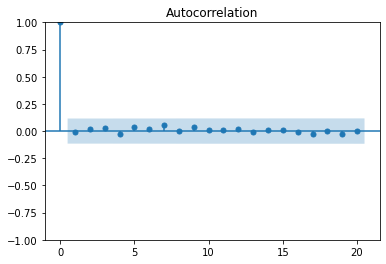

In [289]:
resid = res.resid
plot_acf(resid, lags=20);

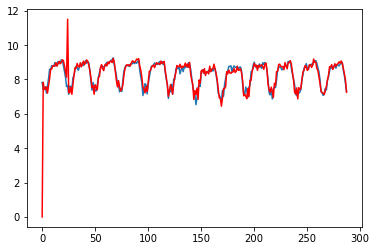

In [290]:
plt.plot(df1_log)
plt.plot(res.fittedvalues, color='red')

In [291]:
forecast_1= res.forecast(steps=df1_log.shape[0])

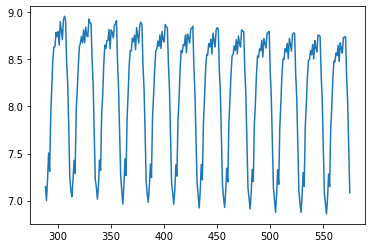

In [293]:
plt.plot(forecast_1)

In [300]:
type(forecast_1)

pandas.core.series.Series

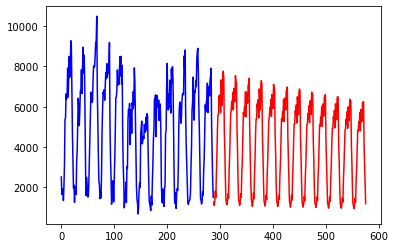

In [307]:
plt.plot(df1, color = 'blue')
plt.plot(np.exp(forecast_1), color = 'red')

In [304]:
df2 = df1.append(np.exp(forecast_1))

# Значение выручки за 2023

In [351]:
sum(np.exp(forecast_1))

1202263.0690817882

## Сравним полученное предсказание с моделью auto_arima 

In [310]:
from pmdarima.arima import auto_arima

In [311]:
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

In [321]:
model = auto_arima(df1_log, start_p=0, start_q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  288
Model:               SARIMAX(3, 0, 1)   Log Likelihood                 -19.848
Date:                Fri, 02 Dec 2022   AIC                             51.696
Time:                        15:34:18   BIC                             73.674
Sample:                             0   HQIC                            60.503
                                - 288                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7359      0.099      7.439      0.000       0.542       0.930
ar.L1          1.6903      0.070     24.299      0.000       1.554       1.827
ar.L2         -0.6342      0.119     -5.344      0.000      -0.867      -0.402
ar.L3         -0.1446      0.061     -2.384      0.017      -0.264      -0.026
ma.L1         -0.8147      0.055    -14.893      0.000      -0.922      -0.707
sigma2         0.0661      0.006     11.376      0.000       0.055       0.077
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.68   Prob(JB):                         0.09
Heteroskedasticity (H):               0.98   Skew:                            -0.31
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

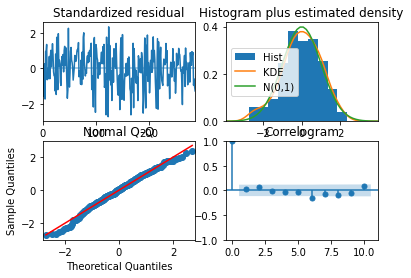

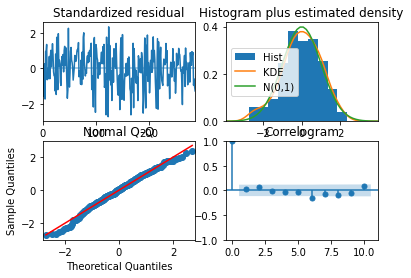

In [322]:
model.plot_diagnostics()

In [323]:
forecast = model.predict(df1.shape[0], df1_log)

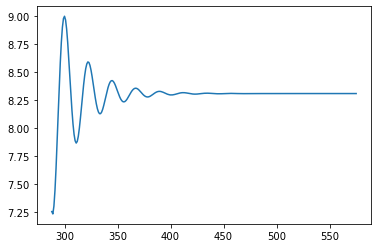

In [324]:
plt.plot(forecast)

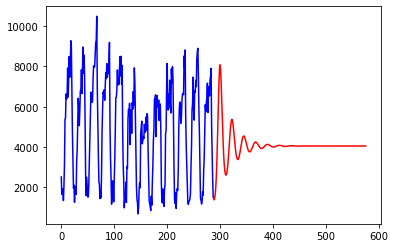

In [325]:
plt.plot(df1, color = 'blue')
plt.plot(np.exp(forecast), color = 'red')

С точки зрения критерия AIC и полученных результатов, модель, подобранная руками, была лучше.

Чтобы учесть то, что новых пользователей больше нет, можно также воспользоваться алгоритмами ml